In [224]:
import os
import urllib.request
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

In [225]:
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
fname = 'jena_climate_2009_2016.csv.zip'

urllib.request.urlretrieve(url, fname)
zip_path = os.path.abspath(fname)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(zip_path))

csv_path, _ = os.path.splitext(zip_path)

In [226]:
df = pd.read_csv(csv_path)

# Hourly sampling
df = df[5::6].reset_index(drop=True)

df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df = df.set_index('Date Time')

# Check time continuity
print(f"Time range: {df.index.min()} to {df.index.max()}")
print(f"Total hours: {len(df)}")
print(f"Expected hours (8 years): {365*8*24 + 2*24} (accounting for 2 leap days)")

# Check for missing hours
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
print(f"Missing entries: {len(full_range) - len(df)}")

Time range: 2009-01-01 01:00:00 to 2016-12-31 23:10:00
Total hours: 70091
Expected hours (8 years): 70128 (accounting for 2 leap days)
Missing entries: 36


In [227]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [228]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [229]:
# Remove erroneous values seen in summary stats
df['wv (m/s)'] = df['wv (m/s)'].where(df['wv (m/s)'] >= 0, 0)
df['max. wv (m/s)'] = df['max. wv (m/s)'].where(df['max. wv (m/s)'] >= 0, 0)

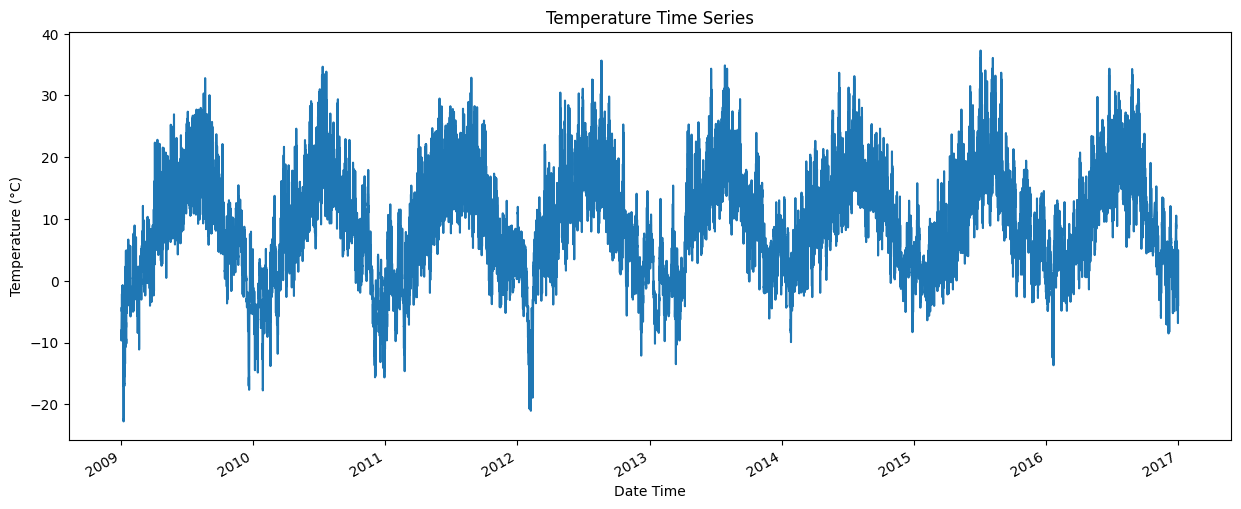

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


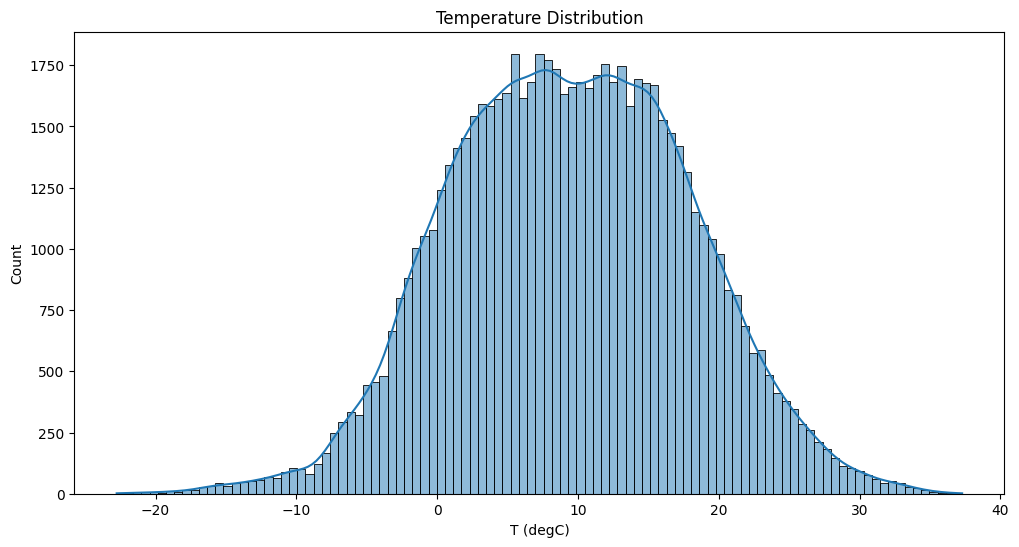

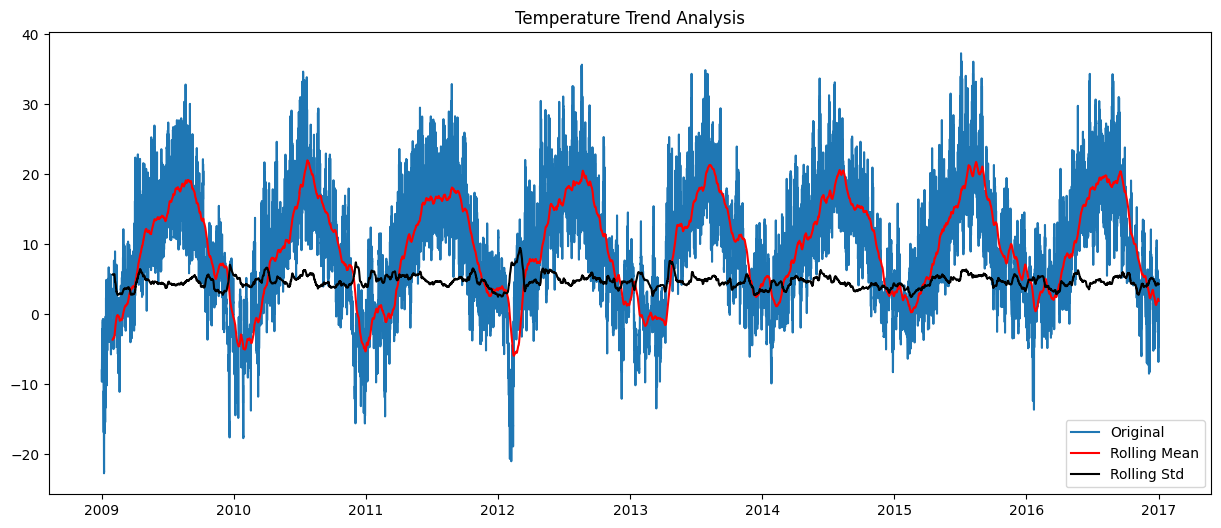

In [230]:
plt.figure(figsize=(15, 6))
df['T (degC)'].plot(title='Temperature Time Series')
plt.ylabel('Temperature (°C)')
plt.show()

# Distribution analysis
plt.figure(figsize=(12, 6))
sns.histplot(df['T (degC)'], kde=True)
plt.title('Temperature Distribution')
plt.show()

# Rolling stats
temp_series = df['T (degC)']
rolling_mean = temp_series.rolling(window=24*30).mean()  # 30-day window
rolling_std = temp_series.rolling(window=24*30).std()

plt.figure(figsize=(15, 6))
plt.plot(temp_series, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.legend()
plt.title('Temperature Trend Analysis')
plt.show()

In [231]:
from statsmodels.tsa.seasonal import seasonal_decompose

df.sort_index(inplace=True)

# Verify time index properties
print(f"Index is monotonic: {df.index.is_monotonic_increasing}")
print(f"Index is continuous: {df.index.to_series().diff().value_counts()}")

start_date = '2012-01-01'
end_date = '2014-12-31'

# Check if the dates exist in the index
print(f"First available date: {df.index.min()}")
print(f"Last available date: {df.index.max()}")

subset_series = df.loc[start_date:end_date, 'T (degC)']

Index is monotonic: True
Index is continuous: Date Time
0 days 01:00:00    70000
0 days 00:30:00       61
0 days 00:00:00       24
0 days 01:10:00        2
0 days 01:20:00        1
0 days 16:50:00        1
3 days 03:10:00        1
Name: count, dtype: int64
First available date: 2009-01-01 01:00:00
Last available date: 2016-12-31 23:10:00


<Figure size 1200x600 with 0 Axes>

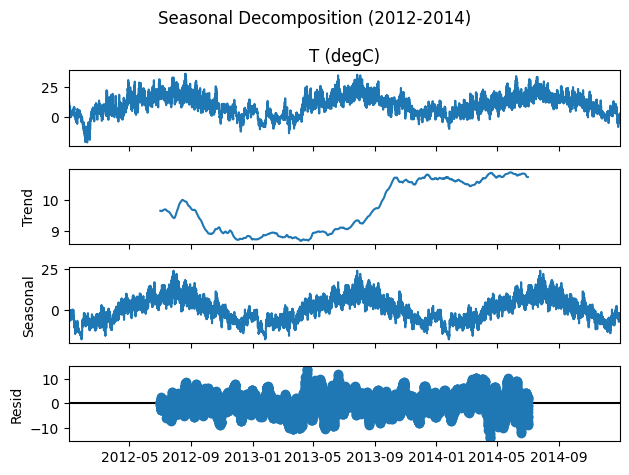

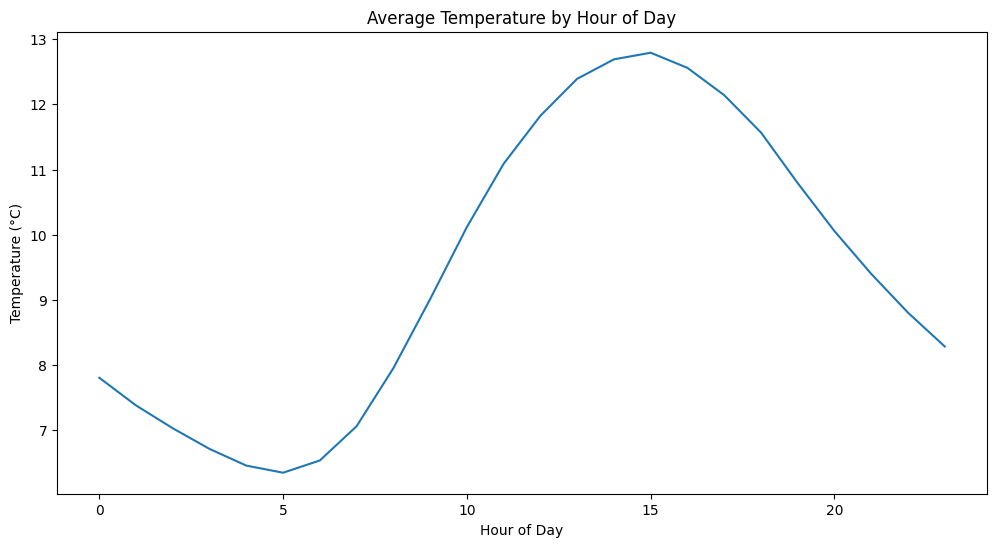

In [232]:
# Seasonal decomposition
result = seasonal_decompose(subset_series, model='additive', period=24*365)
plt.figure(figsize=(12, 6))
result.plot()
plt.suptitle('Seasonal Decomposition (2012-2014)')
plt.tight_layout()
plt.show()

# Daily patterns
hourly_avg = temp_series.groupby(temp_series.index.hour).mean()
plt.figure(figsize=(12, 6))
hourly_avg.plot(kind='line')
plt.title('Average Temperature by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (°C)')
plt.show()

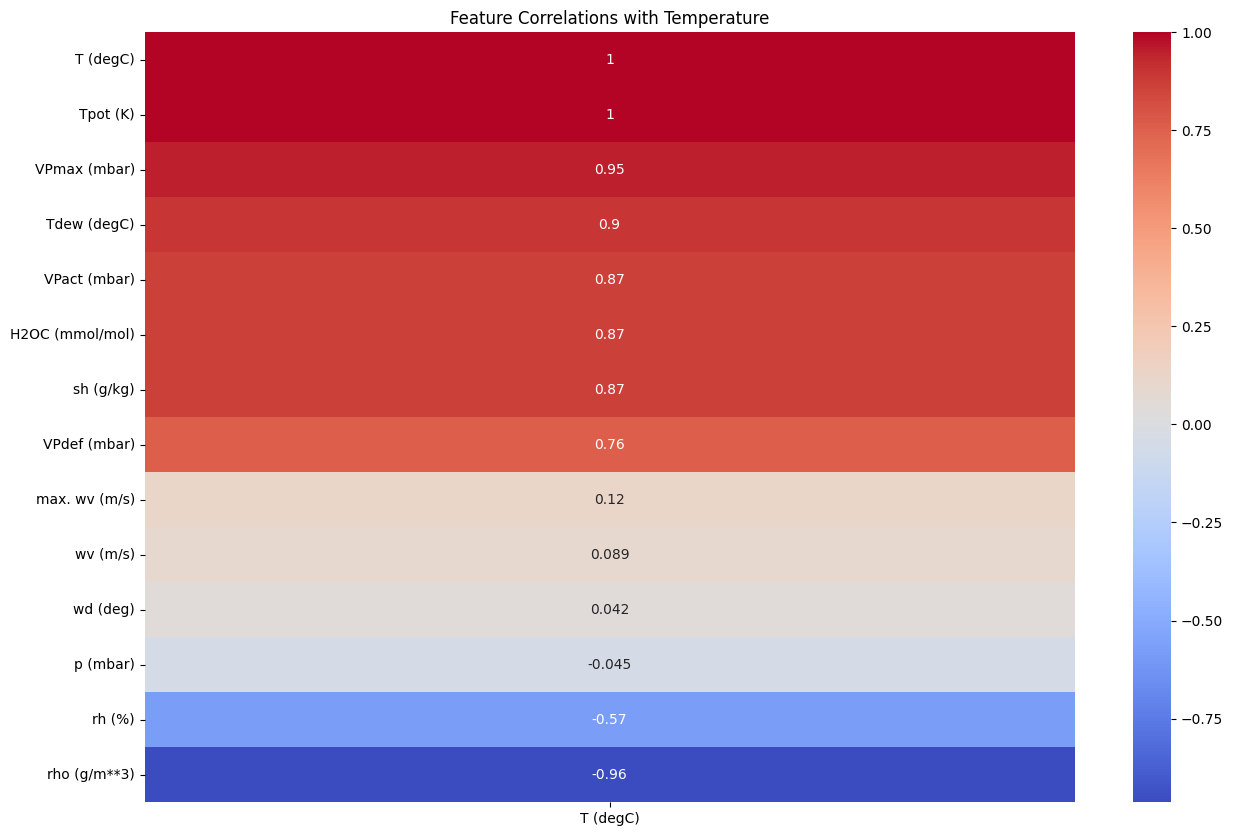

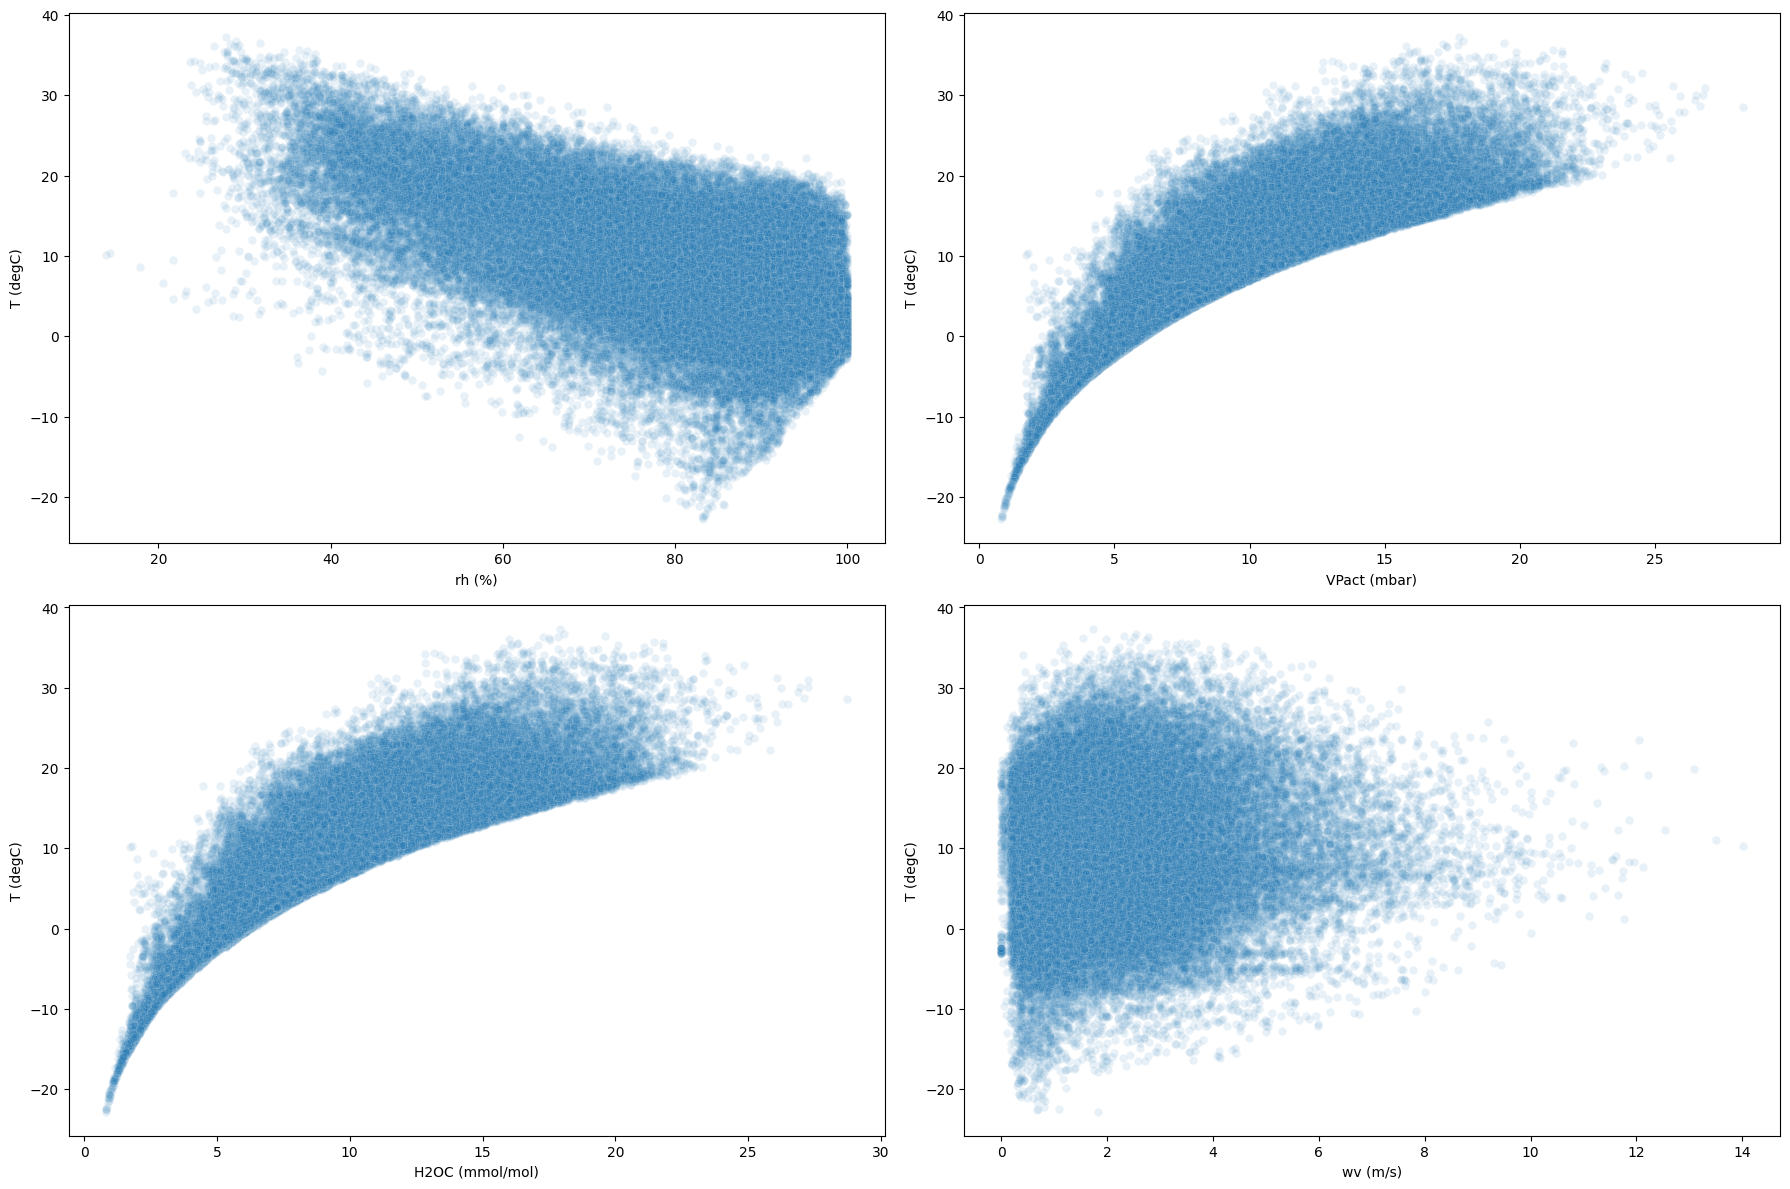

In [233]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix[['T (degC)']].sort_values(by='T (degC)', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Feature Correlations with Temperature')
plt.show()

# Key relationships
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
sns.scatterplot(x='rh (%)', y='T (degC)', data=df, ax=ax[0,0], alpha=0.1)
sns.scatterplot(x='VPact (mbar)', y='T (degC)', data=df, ax=ax[0,1], alpha=0.1)
sns.scatterplot(x='H2OC (mmol/mol)', y='T (degC)', data=df, ax=ax[1,0], alpha=0.1)
sns.scatterplot(x='wv (m/s)', y='T (degC)', data=df, ax=ax[1,1], alpha=0.1)
plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

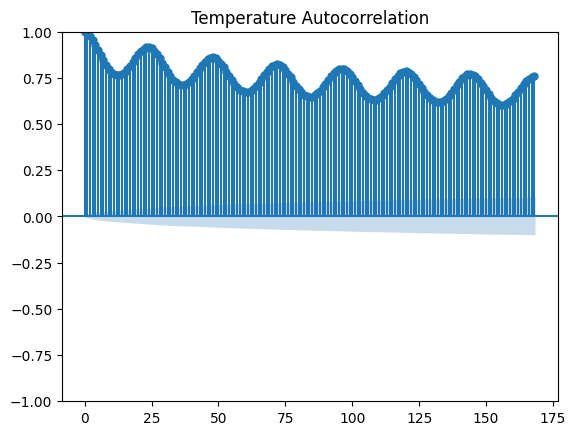

In [234]:
plt.figure(figsize=(15, 6))
plot_acf(temp_series, lags=7*24)  # 1 week of lags
plt.title('Temperature Autocorrelation')
plt.show()

# 12 hour peaks -- seems consistent with day versus night

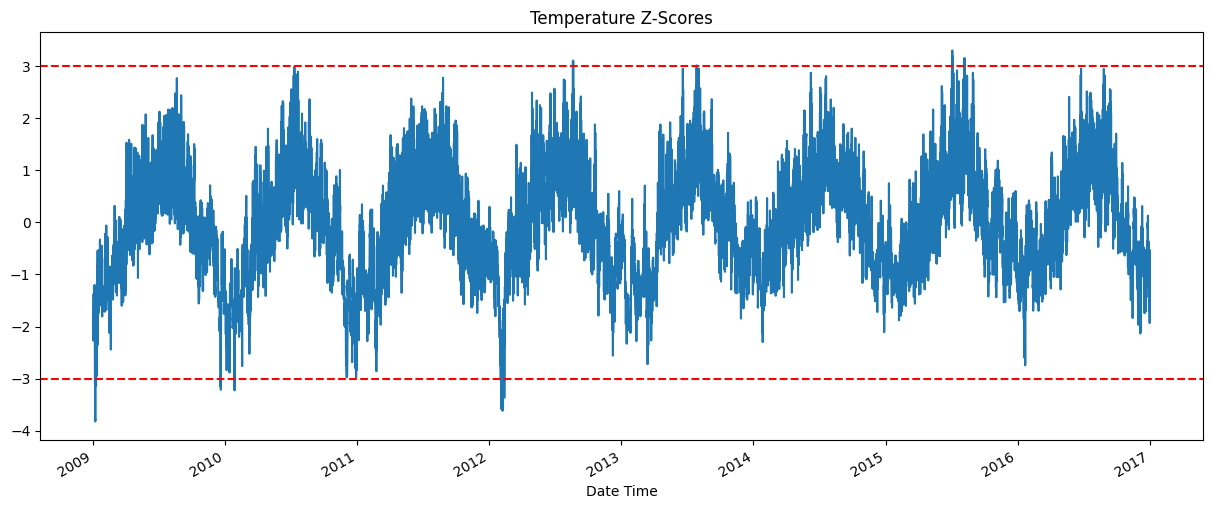

<ipython-input-235-5bb089a8027d>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  extreme_cold = df[temp_series < -15]


Extreme cold events (<-15°C): 187
Extreme heat events (>30°C): 408


<ipython-input-235-5bb089a8027d>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  extreme_heat = df[temp_series > 30]


In [235]:
z_scores = (temp_series - temp_series.mean()) / temp_series.std()
plt.figure(figsize=(15, 6))
z_scores.plot()
plt.axhline(3, color='r', linestyle='--')
plt.axhline(-3, color='r', linestyle='--')
plt.title('Temperature Z-Scores')
plt.show()

# Temperature extremes analysis
extreme_cold = df[temp_series < -15]
extreme_heat = df[temp_series > 30]
print(f"Extreme cold events (<-15°C): {len(extreme_cold)}")
print(f"Extreme heat events (>30°C): {len(extreme_heat)}")

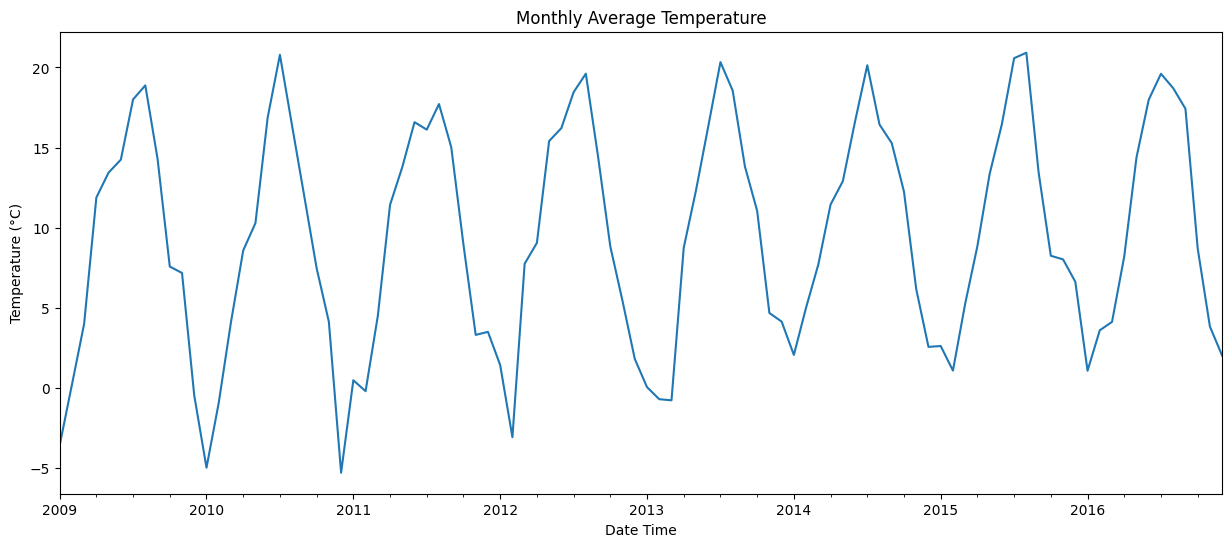

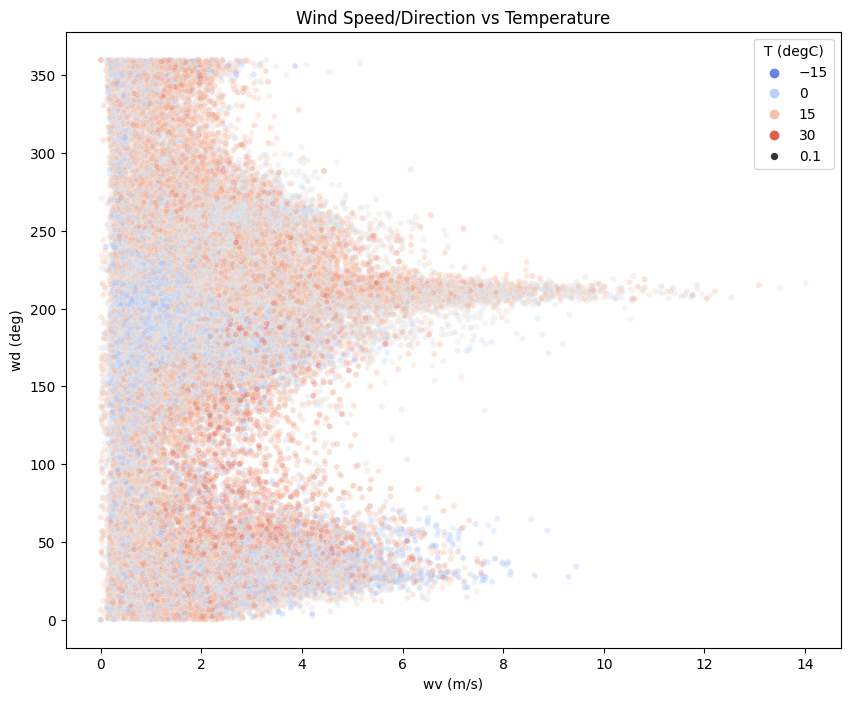

In [236]:
# Annual cycle
monthly_avg = temp_series.resample('ME').mean()
plt.figure(figsize=(15, 6))
monthly_avg.plot()
plt.title('Monthly Average Temperature')
plt.ylabel('Temperature (°C)')
plt.show()

# Wind patterns
plt.figure(figsize=(10, 8))
sns.scatterplot(x='wv (m/s)', y='wd (deg)', data=df, 
                hue='T (degC)', palette='coolwarm', 
                alpha=0.3, size=0.1)
plt.title('Wind Speed/Direction vs Temperature')
plt.show()

In [237]:
def clean_time_series(df):
    # Handle duplicates first
    print(f"Initial duplicates: {df.index.duplicated().sum()}")
    df = df[~df.index.duplicated(keep='first')]
    
    # Now handle missing values
    df = df.resample('h').asfreq()  # Ensure hourly frequency
    print(f"Missing values before interpolation: {df.isnull().sum().sum()}")
    
    # Time-aware interpolation (linear for continuous values)
    df = df.interpolate(method='time')
    
    print(f"Missing values after handling: {df.isnull().sum().sum()}")
    return df

df = clean_time_series(df)

Initial duplicates: 24
Missing values before interpolation: 587524
Missing values after handling: 0


In [238]:
# Verify Index Properties
def check_index(df):
    print(f"1. Unique: {df.index.is_unique}")
    print(f"2. Monotonic: {df.index.is_monotonic_increasing}")
    print(f"3. Start: {df.index.min()}")
    print(f"4. End: {df.index.max()}")
    print(f"5. Total entries: {len(df)}")
    print(f"6. Sample index:\n{df.index[:5]}")

check_index(df)

1. Unique: True
2. Monotonic: True
3. Start: 2009-01-01 01:00:00
4. End: 2016-12-31 23:00:00
5. Total entries: 70127
6. Sample index:
DatetimeIndex(['2009-01-01 01:00:00', '2009-01-01 02:00:00',
               '2009-01-01 03:00:00', '2009-01-01 04:00:00',
               '2009-01-01 05:00:00'],
              dtype='datetime64[ns]', name='Date Time', freq='h')


In [239]:
target = 'T (degC)'
features = [col for col in df.columns if col != target]

feature_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))

df[features] = feature_scaler.fit_transform(df[features])
df[[target]] = target_scaler.fit_transform(df[[target]])

In [240]:
# Values determined by ACF plot inspection
LOOKBACK = 12 
HORIZON = 12

def create_sequences(data, lookback=12, horizon=12, target_col_idx=0):
    X, y = [], []
    for i in range(len(data) - lookback - horizon):
        X.append(data[i:(i + lookback)])
        y.append(data[i + lookback:i + lookback + horizon, target_col_idx])
    return np.array(X), np.array(y)

target_col_idx = df.columns.get_loc('T (degC)')

data = df.values

# Create sequences with explicit target position
X, y = create_sequences(data, LOOKBACK, HORIZON, target_col_idx)

print(f"Input shape: {X.shape}")  # (samples, lookback, features)
print(f"Target shape: {y.shape}") # (samples, horizon)

Input shape: (70103, 12, 14)
Target shape: (70103, 12)


In [241]:
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, X_rem, y_train, y_rem = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
X_val, X_test, y_val, y_test = X_rem[:val_size], X_rem[val_size:], y_rem[:val_size], y_rem[val_size:]

print(f"Train sizes: {X_train.shape}, {y_train.shape}")
print(f"Val sizes: {X_val.shape}, {y_val.shape}")
print(f"Test sizes: {X_test.shape}, {y_test.shape}")

Train sizes: (49072, 12, 14), (49072, 12)
Val sizes: (10515, 12, 14), (10515, 12)
Test sizes: (10516, 12, 14), (10516, 12)


In [242]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [243]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TemperatureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, HORIZON)
        
    def forward(self, x):
        out, _ = self.lstm(x)  # out: [batch, seq_len, hidden_size]
        return self.fc(out[:, -1, :])  # Last timestep

# Initialize model
model = TemperatureLSTM(input_size=data.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [244]:
def train_model(model, train_loader, val_loader, device, epochs=10):
    best_loss = float('inf')
    train_losses, val_losses = [], []
        
    with tqdm(total=epochs, desc='Training Progress', unit='epoch') as pbar:
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False)
            for X_batch, y_batch in train_pbar:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_pbar.set_postfix({'batch_loss': loss.item()})
            train_pbar.close()
            
            model.eval()
            val_loss = 0
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False)
            with torch.no_grad():
                for X_val, y_val in val_pbar:
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    outputs = model(X_val)
                    loss = criterion(outputs, y_val)
                    val_loss += loss.item()
                    val_pbar.set_postfix({'batch_loss': loss.item()})
            val_pbar.close()
    
            avg_train = train_loss / len(train_loader)
            avg_val = val_loss / len(val_loader)
            train_losses.append(avg_train)
            val_losses.append(avg_val)
            
            pbar.set_postfix({
                'train_loss': f'{avg_train:.4f}',
                'val_loss': f'{avg_val:.4f}',
                'best_val': f'{best_loss:.4f}'
            })
            pbar.update(1)
            
            # Save best model
            if avg_val < best_loss:
                best_loss = avg_val
                torch.save(model.state_dict(), 'best_model.pth')


    # Plot history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training History')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()
    
    return train_losses, val_losses

Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

Epoch 1/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 2/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 3/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 4/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 5/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 6/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 7/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 8/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 9/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 10/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 11/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 12/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 13/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 14/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 15/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 16/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 17/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 18/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 19/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 20/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 21/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 22/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 23/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 24/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 25/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 26/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 27/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 28/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 29/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 30/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 31/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 32/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 33/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 34/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 35/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 36/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 37/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 38/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 39/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 40/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 41/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 42/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 43/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 44/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 45/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 46/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 47/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 48/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 49/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 50/50 [Train]:   0%|          | 0/767 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/165 [00:00<?, ?it/s]

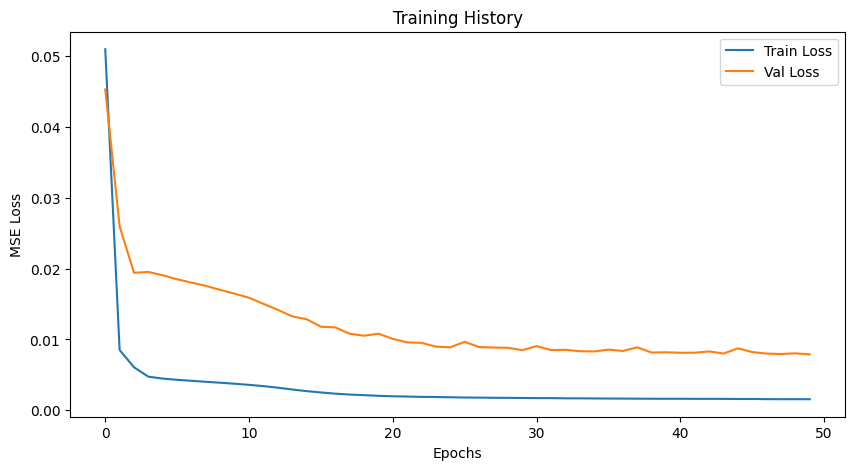

In [245]:
EPOCHS = 50

train_losses, val_losses = train_model(model, train_loader, val_loader, device, epochs=EPOCHS)

In [249]:
# For forecasting and evaluation
def inverse_transform(data, scaler):
    return scaler.inverse_transform(data)

In [250]:
def evaluate_model(model, test_loader, device, n_samples=3):
    model.eval()
    predictions, actuals = [], []
    
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            preds = model(X_test)
            predictions.append(preds.cpu().numpy())
            actuals.append(y_test.cpu().numpy())
    
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    
    predictions = inverse_transform(predictions, target_scaler)
    actuals = inverse_transform(actuals, target_scaler)
    
    # Plot sample predictions
    plt.figure(figsize=(15, 9))
    for i in range(n_samples):
        idx = np.random.randint(0, len(predictions))
        plt.subplot(n_samples, 1, i+1)
        plt.plot(actuals[idx], label='Actual')
        plt.plot(predictions[idx], label='Predicted')
        plt.title(f'12-Hour Forecast Sample {i+1}')
        plt.ylabel('Temperature (°C)')
        plt.legend()
    plt.tight_layout()
    plt.show()
    
    mse = np.mean((predictions - actuals)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    
    print(f'Test MSE: {mse:.2f}')
    print(f'Test RMSE: {rmse:.2f}°C')
    print(f'Test MAE: {mae:.2f}°C')
    
    return predictions, actuals

<ipython-input-251-e464e6653732>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


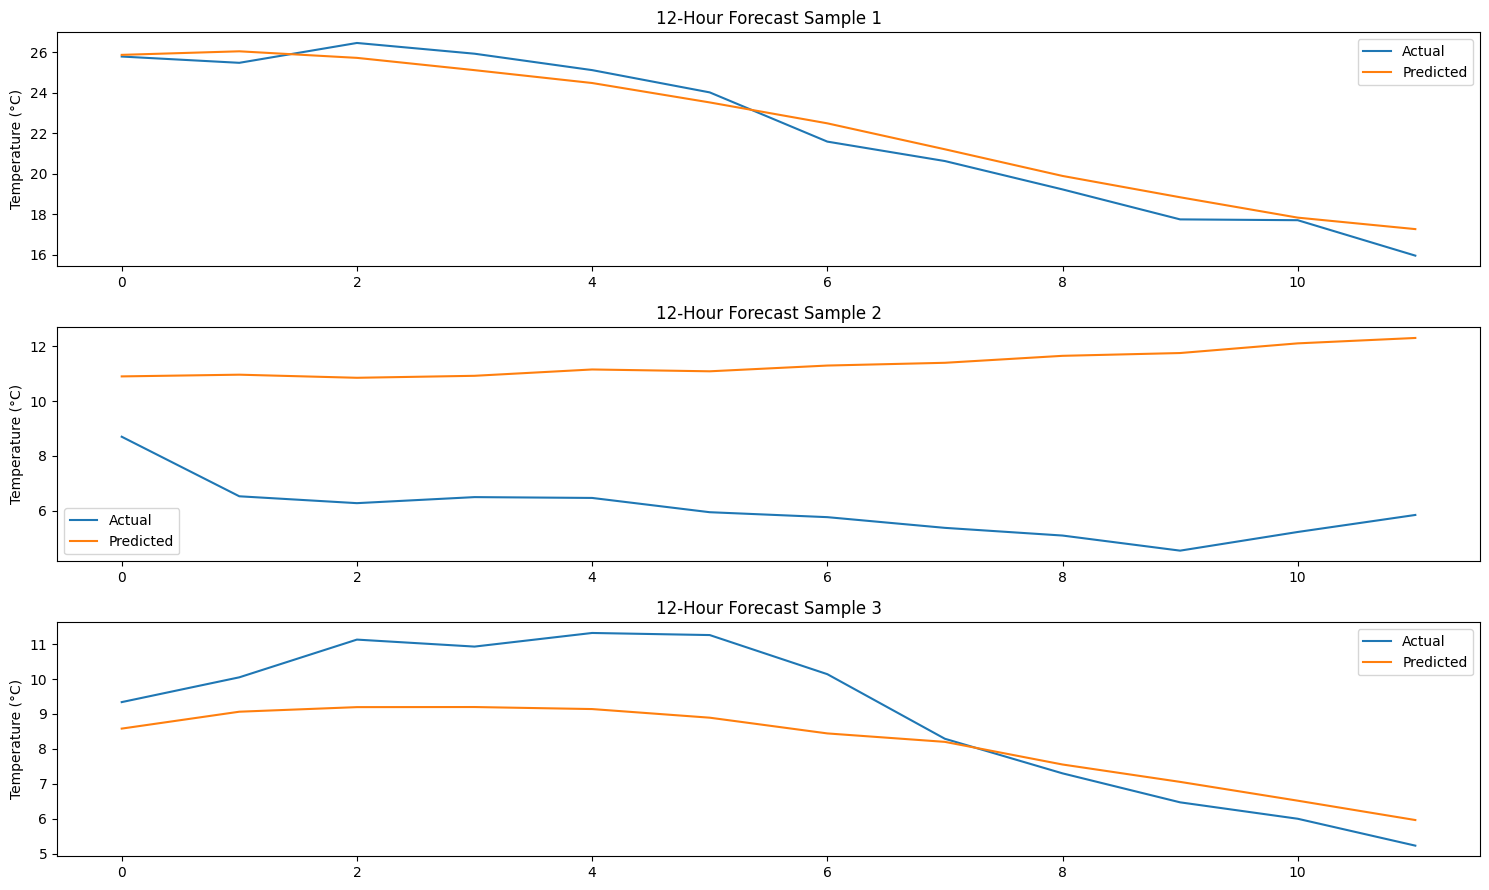

Test MSE: 7.30
Test RMSE: 2.70°C
Test MAE: 2.09°C


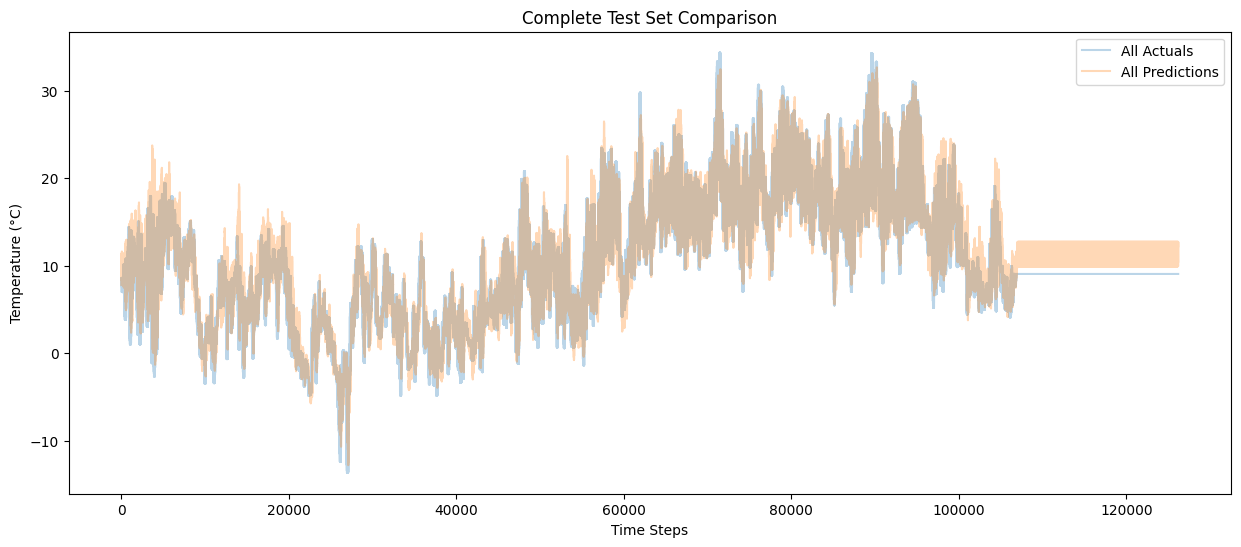

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


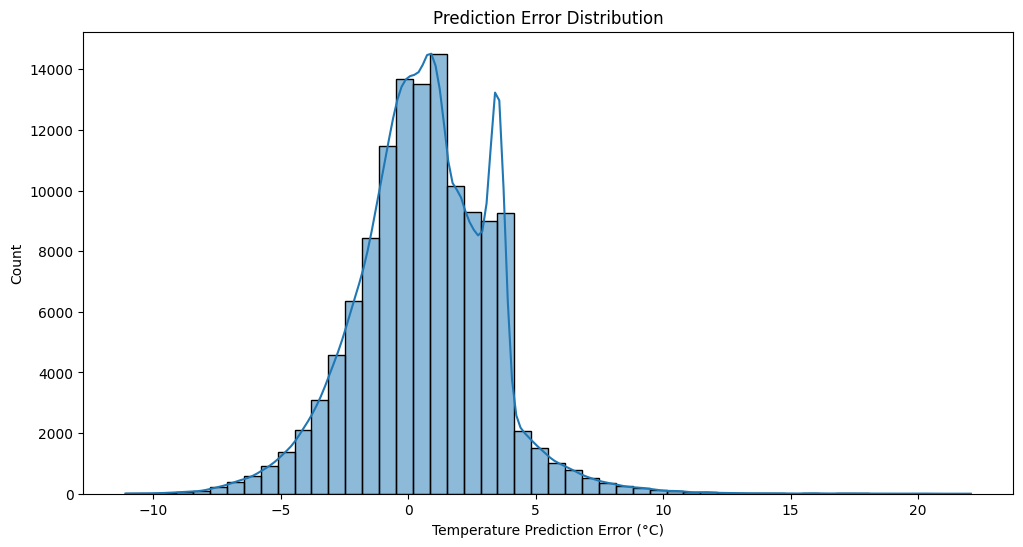

In [251]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate and plot
predictions, actuals = evaluate_model(model, test_loader, device, n_samples=3)

plt.figure(figsize=(15, 6))
plt.plot(actuals.flatten(), alpha=0.3, label='All Actuals')
plt.plot(predictions.flatten(), alpha=0.3, label='All Predictions')
plt.title('Complete Test Set Comparison')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time Steps')
plt.legend()
plt.show()

# Error Distribution Analysis
errors = predictions.flatten() - actuals.flatten()
plt.figure(figsize=(12, 6))
sns.histplot(errors, kde=True, bins=50)
plt.title('Prediction Error Distribution')
plt.xlabel('Temperature Prediction Error (°C)')
plt.show()